In [1]:
import os
from ctypes import *

import numpy as np
import time
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
path_to_dll = "C:/Users/gautier/CLionProjects/MLP_Rattrapage/cmake-build-debug/libMLP3.dll"
mylib = cdll.LoadLibrary(path_to_dll)

In [16]:
X_train = []
Y_train = []
X_test = []
Y_test = []

def import_images_and_assign_labels(folder, label, type, test_image):
    showed = False
    for file in os.listdir(folder):
        image_path = folder + file
        im = Image.open(image_path)
        im = im.resize((32,32))
        im = im.convert("RGB")
        if (type == "test" and test_image == 0 and not showed):
#            im.show()
            showed = True
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (32 * 32 * 3))
        if (type == "train"):
            X_train.append(im_arr)
            Y_train.append(label)
        else:
            X_test.append(im_arr)
            Y_test.append(label)

def import_dataset():
    dataset_folder = "C:/Users/gautier/CLionProjects/MLP_Rattrapage/Datasets"
    train_folder = dataset_folder + "/train"
    test_folder = dataset_folder + "/test"
    import_images_and_assign_labels(train_folder + "/basque_flag/", [1, -1, -1], "train", -1)
    import_images_and_assign_labels(train_folder + "/belgium_flag/", [-1, 1, -1], "train", -1)
    import_images_and_assign_labels(train_folder + "/french_flag/", [-1, -1, 1], "train", -1)
    import_images_and_assign_labels(test_folder + "/basque_flag/", [1, -1, -1], "test", 0)
    import_images_and_assign_labels(test_folder + "/belgium_flag/", [-1, 1, -1], "test", -1)
    import_images_and_assign_labels(test_folder + "/french_flag/", [-1, -1, 1], "test", -1)
    return (np.array(X_train) / 255.0, np.array(Y_train)), (np.array(X_test) / 255.0, np.array(Y_test))


In [23]:
def run_train():
    (X_train, Y_train), (X_test, Y_test) = import_dataset()
    dataset_inputs = np.array(X_train)
    dataset_expected_outputs = np.array(Y_train)
    #init_tab = [2, 3]
    init_tab = [2, 32, 32, 3]
    init_size = len(init_tab)
    init_type = c_int * init_size
    init = init_type(*init_tab)
    mylib.create_mlp_model.argtypes = [init_type, c_int]
    mylib.create_mlp_model.restype = c_void_p
    model1 = mylib.create_mlp_model(init, int(init_size))
    test_dataset = X_test
    #img_test = [X_test[0]]
    img_test = X_test
    colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in dataset_expected_outputs]
    mylib.getXSize.argtypes = [c_void_p]
    mylib.getXSize.restype = c_int
    tmp_len = mylib.getXSize(model1)

    flattened_dataset_inputs = []
    for p in dataset_inputs :
        flattened_dataset_inputs.append(p[0])
        flattened_dataset_inputs.append(p[1])    
    flattened_dataset_outputs = []
    for p in dataset_expected_outputs:
        flattened_dataset_outputs.append(p[0])
        flattened_dataset_outputs.append(p[1])
        flattened_dataset_outputs.append(p[2])

    arrsize_flat = len(flattened_dataset_inputs)
    arrtype_flat = c_float * arrsize_flat
    arr_flat = arrtype_flat(*flattened_dataset_inputs)
    arrsize_exp = len(flattened_dataset_outputs)
    arrtype_exp = c_float * arrsize_exp
    arr_exp = arrtype_exp(*flattened_dataset_outputs)
    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.argtypes = [c_void_p, arrtype_flat, c_int,
                                                                                         arrtype_exp, c_float, c_int]
    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.restype = None
    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model(model1, arr_flat, arrsize_flat, arr_exp,
                                                                             0.0001, 100000)
    
    predicted_outputs = []
    i = 0
    correct = 0
    for p in img_test :
        arrsizeP = len(p)
        arrtypeP = c_float * arrsizeP
        arrP = arrtypeP(*p)
        mylib.predict_mlp_model_classification.argtypes = [c_void_p, arrtypeP]
        mylib.predict_mlp_model_classification.restype = POINTER(c_float)
        tmp = mylib.predict_mlp_model_classification(model1, arrP)
        np_arr = np.ctypeslib.as_array(tmp, (tmp_len,))
        print(np_arr)
        predicted_outputs.append(np_arr)
        if predicted_outputs[i][0] > predicted_outputs[i][1] and predicted_outputs[i][0] > predicted_outputs[i][2]:
            if (np.array_equal(Y_test[i], [1, -1, -1])):
                correct += 1
            print("Basque flag")
        elif predicted_outputs[i][1] > predicted_outputs[i][0] and predicted_outputs[i][1] > predicted_outputs[i][2]:
            if (np.array_equal(Y_test[i], [-1, 1, -1])):
                correct += 1
            print("Belgium flag")
        else :
            if (np.array_equal(Y_test[i], [-1, -1, 1])):
                correct += 1
            print("French flag")
        i += 1
    accs = [0, correct / i]
    plt.plot(accs)
    plt.legend(['accuracy'], loc='upper left')
    plt.title('Evolution of accuracy')
    plt.xlabel('epochs')
    plt.ylabel(f'accuracy')
    plt.show()

[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.96163285  0.5275937  -0.7084528 ]
Belgium flag
[-0.30999127  0.26221427 -0.6683202 ]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[ 0.43766856 -0.8795453  -0.17802523]
Basque flag
[-0.30369174  0.08368793 -0.6028879 ]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.23922642  0.21103097 -0.8301629 ]
Belgium flag
[-0.9042502   0.31408033 -0.3917048 ]
Belgium flag
[ 0.7491842  -0.66056424 -0.95106643]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.05893023  0.07121185 -0.8824965 ]
Belgium flag
[ 0.67897445 -0.84960294 -0.6942456 ]
Basque flag
[ 0.07566854 -0.63234    -0.880001  ]
Basque flag
[-0.30999127  0.26221427 -0.6683202 ]
Belgium flag
[-0.28312796 -0.18935974 -0.52915406]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basq

[-0.889118    0.5224471  -0.36825326]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.889118    0.5224471  -0.36825326]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.96163285  0.5275937  -0.7084528 ]
Belgium flag
[-0.0928228   0.07932711 -0.87526464]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.25892147 -0.35914752 -0.483571  ]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.92777795  0.5506667  -0.46828902]
Belgium flag
[-0.26540408 -0.36443973 -0.48750576]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.23257032  0.3470018  -0.815467  ]
Belgium flag
[ 0.2510471  -0.73609066 -0.8996167 ]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.30724674  0.15183876 -0.6250903 ]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basqu

[-0.29696572 -0.01874575 -0.5731211 ]
Belgium flag
[ 0.11421981 -0.7336755  -0.5720901 ]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[ 0.81896   -0.7868134 -0.8338121]
Basque flag
[-0.04341985 -0.5896339  -0.62024057]
Basque flag
[ 0.22474585 -0.7156258  -0.9079311 ]
Basque flag
[ 0.4066693  -0.8768718  -0.16053692]
Basque flag
[ 0.7491842  -0.66056424 -0.95106643]
Basque flag
[ 0.16403006 -0.7419768  -0.74832904]
Basque flag
[ 0.41710895 -0.8330316  -0.68543696]
Basque flag
[-0.30369174  0.08368793 -0.6028879 ]
Belgium flag
[-0.05792017  0.08284952 -0.8821776 ]
Belgium flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[ 0.80230045 -0.80647606 -0.7996688 ]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag
[-0.26211274 -0.39268807 -0.48089844]
Basque flag


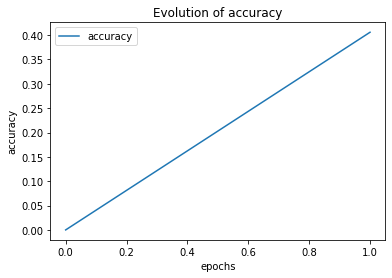

In [24]:
if __name__ == "__main__":
    run_train()